# <b style="color: #151151">Lab 2 - Arend Wong (aw3146) - 2021-05-21<b>

<i style='color: blue;'>
Due Monday by 11:59pm Points 100 Submitting a website url or a file upload
Lab #2

1. Recode 2 different variables into new categories. They can both be continuous-ish or both be nominal-ish, or one of each. Tell me what you did and explain the variable(s).

2. Use one (or both) of your recoded variables to do a cross-tabulation. Explain your results.

3. Run a linear regression with 1 independent and 1 dependent variable; make all of the recodes necessary to make the model as easy to interpret as possible; and explain your results.

4. Plot two variables, either as a scatter plot or boxplot; add in trend/regression lines; and explain your results.
</i>


In [81]:
from __future__ import division
import pandas as pd
import numpy as np
import re, os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
# Read CSV into a dataframe
url = "https://raw.githubusercontent.com/the-pudding/data/master/pockets/measurements.csv"
df = pd.read_csv(url) # https://github.com/the-pudding/data/blob/master/pockets/measurements.csv
df

,brand,style,menWomen,name,fabric,price,maxHeightFront,minHeightFront,rivetHeightFront,maxWidthFront,minWidthFront,maxHeightBack,minHeightBack,maxWidthBack,minWidthBack,cutout
0,Arizona,skinny,women,Fave Super Skinny,"78% cotton, 20% polyester, 2% spandex",42.00,14.5,15.0,6.5,16.5,13.0,15.0,12.2,13.7,12.0,False
1,Arizona,straight,women,Perfect Boot,"78% cotton, 20% polyester, 2% spandex",42.00,14.5,14.0,6.5,16.0,12.5,15.5,12.2,13.0,11.2,False
2,Ralph Lauren,skinny,women,Modern Skinny Slimming Fit,"92% cotton, 7% poly, 1% elastane",89.50,13.0,13.5,6.5,14.5,12.0,15.5,13.0,13.5,12.5,False
3,Ralph Lauren,straight,women,Premier Straight Slimming Fit,"92% cotton, 7% poly, 1% elastane",89.50,13.0,13.5,6.5,14.5,12.0,14.5,13.0,13.0,12.2,False
4,Uniqlo,skinny,women,Skinny Fit,"87% cotton, 9% polyester, 4% spandex",39.90,13.0,13.0,5.5,14.0,11.5,14.0,12.0,14.2,11.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Wrangler,boot-cut,men,Regular Fit,"99% cotton, 1% spandex",48.00,28.0,15.5,9.0,13.0,12.0,16.7,13.5,14.5,14.0,False
76,Buckle Black,boot-cut,women,Fit No. 76 Bootcut Mid-Rise Curvy,"92% cotton, 6% polyester, 2% spandex",89.95,15.0,14.0,7.0,16.0,13.5,14.5,13.0,13.5,11.0,False
77,Buckle Black,skinny,women,Fit No. 53 Straight Mid-Rise Slim,"98% cotton, 2% elastane",92.95,14.5,13.5,6.0,16.0,13.0,14.0,12.5,14.0,11.5,False
78,Buckle Black,boot-cut,men,Fit No. 9 Bootleg,"92% cotton, 6% polyester, 2% elastane",94.95,21.0,18.5,8.5,18.5,14.5,16.0,14.0,13.0,12.5,False


In [85]:
# Create 3 new columns for PRIMARY material, etc...

df_new = df.copy().assign(
        primary_fabric = df.fabric.apply(lambda s: s.split(', ')[0]),
        primary_fabric_pct = df.fabric.apply(lambda s: s.split(' ')[0].replace('%','')).astype(float).div(100),
        primary_fabric_name = df.fabric.apply(lambda s: s.split(' ')[1].replace(',', ''))
         ).apply(lambda y: y.str.lower().str.strip().replace({'cottton':'cotton'}, regex=True) if str(y.dtype)=='object' else y)

df_new = df_new[df_new.columns[df_new.columns.str.contains('maxHeightBack|minHeightBack|brand|style|men|name|fabric|price|cut|var|val|maxheightback|minheightback')]]
df_new

# df_new.shape # (80, 19)

,brand,style,menWomen,name,fabric,price,maxHeightBack,minHeightBack,cutout,primary_fabric,primary_fabric_pct,primary_fabric_name
0,arizona,skinny,women,fave super skinny,"78% cotton, 20% polyester, 2% spandex",42.00,15.0,12.2,False,78% cotton,0.78,cotton
1,arizona,straight,women,perfect boot,"78% cotton, 20% polyester, 2% spandex",42.00,15.5,12.2,False,78% cotton,0.78,cotton
2,ralph lauren,skinny,women,modern skinny slimming fit,"92% cotton, 7% poly, 1% elastane",89.50,15.5,13.0,False,92% cotton,0.92,cotton
3,ralph lauren,straight,women,premier straight slimming fit,"92% cotton, 7% poly, 1% elastane",89.50,14.5,13.0,False,92% cotton,0.92,cotton
4,uniqlo,skinny,women,skinny fit,"87% cotton, 9% polyester, 4% spandex",39.90,14.0,12.0,False,87% cotton,0.87,cotton
...,...,...,...,...,...,...,...,...,...,...,...,...
75,wrangler,boot-cut,men,regular fit,"99% cotton, 1% spandex",48.00,16.7,13.5,False,99% cotton,0.99,cotton
76,buckle black,boot-cut,women,fit no. 76 bootcut mid-rise curvy,"92% cotton, 6% polyester, 2% spandex",89.95,14.5,13.0,False,92% cotton,0.92,cotton
77,buckle black,skinny,women,fit no. 53 straight mid-rise slim,"98% cotton, 2% elastane",92.95,14.0,12.5,False,98% cotton,0.98,cotton
78,buckle black,boot-cut,men,fit no. 9 bootleg,"92% cotton, 6% polyester, 2% elastane",94.95,16.0,14.0,False,92% cotton,0.92,cotton


In [87]:
df_new.columns

Index(['brand', 'style', 'menWomen', 'name', 'fabric', 'price',
       'maxHeightBack', 'minHeightBack', 'cutout', 'primary_fabric',
       'primary_fabric_pct', 'primary_fabric_name'],
      dtype='object')

In [88]:
df_new.primary_fabric_name.value_counts()

cotton    79
rayon      1
Name: primary_fabric_name, dtype: int64

In [89]:
print(df_new['brand'].value_counts())
print(df_new['primary_fabric_name'].value_counts())


7 for all mankind    4
ralph lauren         4
calvin klein         4
american eagle       4
old navy             4
gap                  4
uniqlo               4
true religion        4
lee                  4
tommy hilfiger       4
j. crew              4
buckle black         4
guess                4
arizona              4
lucky                4
wrangler             4
h&m                  4
levi's               4
abercrombie          4
express              4
Name: brand, dtype: int64
cotton    79
rayon      1
Name: primary_fabric_name, dtype: int64


In [90]:
df_new0 = df_new.copy()
# df_new0['id'] = df.index
# pd.wide_to_long(df_copy, ["A", "B"], i="id", j="year")
df_new0['fabric0_name'], df_new0['fabric1_name'], df_new0['fabric2_name'] = df_new0['fabric'].str.split(',', 2).str
# df_new['fabric0_name'], df_new['fabric1_name'], df_new['fabric2_name'] = df['fabric'].str.split(',', 2).str
df_new0 = df_new0.apply(lambda y: y.replace({'.*%':'', ',':'', '  ':' '}, regex=True).str.strip() if '_name' in y.name else y)
df_new0 = pd.melt(df_new0, id_vars=['brand', 'style', 'menWomen', 'name', 'fabric', 'price', 'cutout','maxHeightBack', 'minHeightBack',
       'primary_fabric', 'primary_fabric_pct', 'primary_fabric_name'])#.rename(columns={'value':'fabric_name_indiv'})
print("our dataframe's OLD shape (rows, columns):", df_new.shape,
      "\nour dataframe's NEW shape (rows, columns):", df_new0.shape)
df_new0 = df_new0.reset_index(drop=True).rename(columns={'value':'fabric_name_indiv'})
df_new0


our dataframe's OLD shape (rows, columns): (80, 12) 
our dataframe's NEW shape (rows, columns): (240, 14)


<ipython-input-90-f146f2fdc2d5>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_new0['fabric0_name'], df_new0['fabric1_name'], df_new0['fabric2_name'] = df_new0['fabric'].str.split(',', 2).str


,brand,style,menWomen,name,fabric,price,cutout,maxHeightBack,minHeightBack,primary_fabric,primary_fabric_pct,primary_fabric_name,variable,fabric_name_indiv
0,arizona,skinny,women,fave super skinny,"78% cotton, 20% polyester, 2% spandex",42.00,False,15.0,12.2,78% cotton,0.78,cotton,fabric0_name,cotton
1,arizona,straight,women,perfect boot,"78% cotton, 20% polyester, 2% spandex",42.00,False,15.5,12.2,78% cotton,0.78,cotton,fabric0_name,cotton
2,ralph lauren,skinny,women,modern skinny slimming fit,"92% cotton, 7% poly, 1% elastane",89.50,False,15.5,13.0,92% cotton,0.92,cotton,fabric0_name,cotton
3,ralph lauren,straight,women,premier straight slimming fit,"92% cotton, 7% poly, 1% elastane",89.50,False,14.5,13.0,92% cotton,0.92,cotton,fabric0_name,cotton
4,uniqlo,skinny,women,skinny fit,"87% cotton, 9% polyester, 4% spandex",39.90,False,14.0,12.0,87% cotton,0.87,cotton,fabric0_name,cotton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,wrangler,boot-cut,men,regular fit,"99% cotton, 1% spandex",48.00,False,16.7,13.5,99% cotton,0.99,cotton,fabric2_name,NaN
236,buckle black,boot-cut,women,fit no. 76 bootcut mid-rise curvy,"92% cotton, 6% polyester, 2% spandex",89.95,False,14.5,13.0,92% cotton,0.92,cotton,fabric2_name,spandex
237,buckle black,skinny,women,fit no. 53 straight mid-rise slim,"98% cotton, 2% elastane",92.95,False,14.0,12.5,98% cotton,0.98,cotton,fabric2_name,NaN
238,buckle black,boot-cut,men,fit no. 9 bootleg,"92% cotton, 6% polyester, 2% elastane",94.95,False,16.0,14.0,92% cotton,0.92,cotton,fabric2_name,elastane


In [91]:
df_new0.fabric_name_indiv.value_counts()

cotton          80
elastane        37
polyester       34
spandex         33
poly             4
rayon            4
viscose          3
modal            2
elasterell-p     1
other fiber      1
Name: fabric_name_indiv, dtype: int64

In [92]:
# Crosstabulation...
pd.crosstab(df_new0.fabric_name_indiv, [df_new0.brand], rownames=['fabric_name_indiv'], colnames=['brand'])

brand,7 for all mankind,abercrombie,american eagle,arizona,buckle black,calvin klein,express,gap,guess,h&m,j. crew,lee,levi's,lucky,old navy,ralph lauren,tommy hilfiger,true religion,uniqlo,wrangler
fabric_name_indiv,,,,,,,,,,,,,,,,,,,,
cotton,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
elastane,0,4,3,0,2,3,0,0,2,3,4,0,3,4,0,2,3,4,0,0
elasterell-p,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
modal,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
other fiber,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
poly,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1
polyester,3,2,2,3,3,0,3,2,1,2,4,1,1,1,2,0,1,1,2,0
rayon,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
spandex,3,0,1,3,2,1,4,3,2,0,0,4,0,0,4,0,0,0,3,3


cotton    78
rayon      1
Cotton     1
Name: primary_fabric_name, dtype: int64

In [93]:
# Linear regression
lm = smf.ols(formula = 'price~fabric_name_indiv', data=df_new0).fit()
print (lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9897
Date:                Sun, 23 May 2021   Prob (F-statistic):              0.450
Time:                        19:25:49   Log-Likelihood:                -1039.7
No. Observations:                 199   AIC:                             2099.
Df Residuals:                     189   BIC:                             2132.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [97]:
print(df_new0.describe())
lm = smf.ols(formula = 'price~minHeightBack', data=df_new0).fit()
print (lm.summary()) 

           price  maxHeightBack  minHeightBack  primary_fabric_pct
count  240.00000     240.000000     240.000000          240.000000
mean    80.75000      15.565000      13.026250            0.872250
std     44.36504       0.918444       0.944804            0.141903
min      9.99000      13.000000      10.500000            0.450000
25%     49.95000      15.000000      12.425000            0.787500
50%     73.97500      15.500000      13.000000            0.920000
75%     95.71250      16.050000      13.700000            0.980000
max    249.00000      17.500000      15.000000            1.000000
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1735
Date:                Sun, 23 May 2021   Prob (F-statistic):              0.677
Ti

In [79]:
# p_value = 0.077 
# comparison factor: cotton
# There is a marginally significant relationship between primary fabric type and price of clothing item. The fabric rayon has, on average, a $79.24 (coefficient of 79.2405) higher price than does cotton (marginally significant with p=.077).
# for each $79.24 increase in 

,price,maxHeightBack,minHeightBack,primary_fabric_pct
count,240.00000,240.000000,240.000000,240.000000
mean,80.75000,15.565000,13.026250,0.872250
std,44.36504,0.918444,0.944804,0.141903
min,9.99000,13.000000,10.500000,0.450000
25%,49.95000,15.000000,12.425000,0.787500
50%,73.97500,15.500000,13.000000,0.920000
75%,95.71250,16.050000,13.700000,0.980000
max,249.00000,17.500000,15.000000,1.000000


In [80]:
# Plots!

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='minHeightBack'>

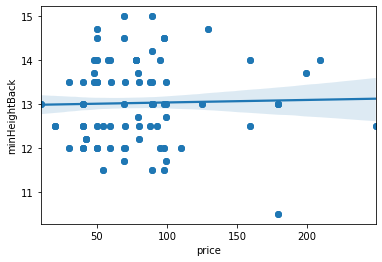

In [98]:
sns.regplot(df_new0['price'],df_new0['minHeightBack'])